# Imports

In [133]:
import requests
from bs4 import BeautifulSoup
import re
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import urllib.request
import webbrowser

import time

from sklearn.linear_model import LinearRegression

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Functions to format strings

In [13]:
def format_baths(baths_str):

    if '-' in baths_str:
        left, right = baths_str.split(' - ')
        return format_baths(left) + ' - ' + format_baths(right)

    return re.findall(r'\d+', baths_str)[0]

In [14]:
def format_beds(beds_str):

    if '-' in beds_str:
        left, right = beds_str.split(' - ')
        return format_beds(left) + ' - ' + format_beds(right)

    if beds_str == 'Studio':
        return '0'

    return re.findall(r'\d+', beds_str)[0]

# Main work horse
This function loops over each property in the `properties` list and gets data from it. It formats the data into a semi-workable format. It temporarily saves this data in a dictionary before converting to a Pandas DataFrame.

In [15]:
def get_property_df(properties):

    property_data = {
        'buy_type': [],
        'desc': [],
        'address': [],
        'price': [],
        'beds': [],
        'baths': [],
        'sqft': [],
        'pets': []
    }

    for property in properties:

        try:
            prop_description = property.find_all('div', attrs={'data-testid': 'card-description'})[0].text
            
            rent_or_sale = prop_description.split(' ')[1].lower()
            house_or_apartment = prop_description.split(' ')[3].lower()

            price = property.find_all('div', attrs={'data-testid': 'card-price'})[0].text

            address_line_1 = property.find_all('div', attrs={'data-testid': 'card-address-1'})[0].text
            address_line_2 = property.find_all('div', attrs={'data-testid': 'card-address-2'})[0].text
            address = address_line_1 + ', ' + address_line_2

            beds = property.find_all('li', attrs={'data-testid': 'property-meta-beds'})
            if len(beds) == 0:
                beds = 'nan'
            else:
                beds = format_beds(beds[0].text)
            
            baths = property.find_all('li', attrs={'data-testid': 'property-meta-baths'})
            if len(baths) == 0:
                baths = 'nan'
            else:
                baths = format_baths(baths[0].text)

            sqft = property.find_all('li', attrs={'data-testid': 'property-meta-sqft'})
            if len(sqft) == 0:
                sqft = 'nan'
            else:
                sqft = sqft[0].text
                sqft = sqft.split('sqft')[0]

            pets = property.find_all('li', attrs={'data-testid': 'property-meta-pet'})
            if len(pets) == 0:
                pets = 'nan'
            else:
                pets = pets[0].text
                pets = pets.split('OK')[0]
                pets = pets.lower()
                if pets == 'pets':
                    pets = 'all pets'

            # try:
            #     image_source = property.find_all('div', attrs={'class': 'Picture_photo-wrap__CDzzG'})[0].find_all('img')[0]['srcset']
            #     if ',' in image_source:
            #         image_source = image_source.split(',')[0]
            #     print(image_source)
            #     # image = requests.get(image_source)
            #     # if image.status_code == 200:
            #     #     urllib.request.urlretrieve(image_source, f"images/{address.replace(' ', '+')}.jpg")
            # except:
            #     continue

            property_data['buy_type'].append(rent_or_sale)
            property_data['desc'].append(house_or_apartment)
            property_data['address'].append(address)
            property_data['price'].append(price)
            property_data['beds'].append(beds)
            property_data['baths'].append(baths)
            property_data['sqft'].append(sqft)
            property_data['pets'].append(pets)

        except IndexError:
            continue

    return pd.DataFrame(property_data)

# Formats minimum and maximum values

In [16]:
def format_min_and_max(value):
    value = value.replace('$', '')
    value = value.replace(',', '')

    if ' - ' in value:
        return value.split(' - ')
    
    return value, value

# Main loop
Loops over pages 1-5 of the Realator.com apartments search page for Greenville, SC. Aggregates Pandas DataFrames from the function `get_property_df`. End result is one DataFrame, `df`, that contains all the data.

In [53]:
min_price = 1000
max_price = 1600

headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"}

df = None

number_of_pages = 8

for page_number in range(1, number_of_pages+1):
    url = f"https://www.realtor.com/apartments/Greenville_SC/pg-{page_number}"

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    properties = soup.find_all('div', attrs={'class': "BasePropertyCard_propertyCardWrap__pblQC"})

    property_df = get_property_df(properties)
    if df is None:
        df = property_df
    else:
        df = pd.concat((df, property_df))

    print(f"Page {page_number} of {number_of_pages} complete.")

Page 1 of 8 complete.
Page 2 of 8 complete.
Page 3 of 8 complete.
Page 4 of 8 complete.
Page 5 of 8 complete.
Page 6 of 8 complete.
Page 7 of 8 complete.
Page 8 of 8 complete.


# Formats data to final form

In [54]:
min_and_max_columns = ['price', 'beds', 'baths', 'sqft']

for col in min_and_max_columns:
    df[[f'min_{col}', f'max_{col}']] = df.apply(lambda x: format_min_and_max(x[col]), axis=1, result_type='expand')

df.drop(columns=min_and_max_columns, inplace=True)
df.reset_index(inplace=True, drop=True)

df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']] = df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']].astype('float')

In [55]:
df

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
0,rent,house,"601 Cleveland St Apt 12D, Greenville, SC 29601",cats,1350.0,1350.0,1.0,1.0,1.0,1.0,NaN,NaN
1,rent,house,"105 McCall St Unit A, Greenville, SC 29601",all pets,4200.0,4200.0,4.0,4.0,3.0,3.0,2600.0,2600.0
2,rent,house,"9 Saint Andrews Way, Greenville, SC 29607",dogs,1560.0,1560.0,3.0,3.0,2.0,2.0,1456.0,1456.0
3,rent,apartment,"1600 Azalea Hill Dr, Greenville, SC 29607",all pets,1119.0,1600.0,0.0,2.0,1.0,2.0,450.0,1100.0
4,rent,apartment,"98 E McBee Ave, Greenville, SC 29601",all pets,1647.0,3437.0,0.0,2.0,1.0,2.0,774.0,1264.0
...,...,...,...,...,...,...,...,...,...,...,...,...
327,rent,townhome,"604 Wenwood Cir, Greenville, SC 29607",nan,1550.0,1550.0,3.0,3.0,2.0,2.0,NaN,NaN
328,rent,house,"240 Alameda St, Greenville, SC 29607",nan,1395.0,1395.0,3.0,3.0,2.0,2.0,1040.0,1040.0
329,rent,house,"28 Clearfield Rd, Greenville, SC 29607",all pets,1950.0,1950.0,4.0,4.0,2.0,2.0,1522.0,1522.0
330,rent,apartment,"1201 Cedar Lane Rd, Greenville, SC 29617",all pets,730.0,1200.0,1.0,3.0,1.0,2.0,600.0,1000.0


# Plots and Analyses

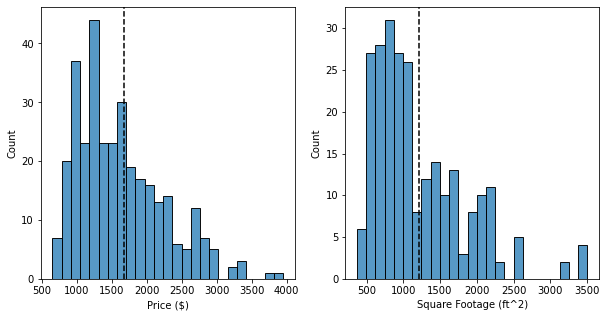

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.histplot(x='min_price', data=df[df['min_price'] < 4000], bins=25, ax=axs[0])
axs[0].axvline(df['min_price'].mean(), linestyle='--', color='k')
axs[0].set_xlabel('Price ($)')

sns.histplot(x='min_sqft', data=df, bins=25, ax=axs[1])
axs[1].axvline(df['min_sqft'].mean(), linestyle='--', color='k')
axs[1].set_xlabel('Square Footage (ft^2)')
plt.show()

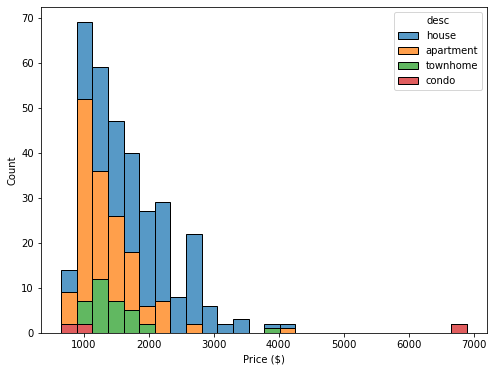

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(x='min_price', data=df, hue='desc', multiple='stack', ax=ax)

plt.xlabel('Price ($)')
plt.show()

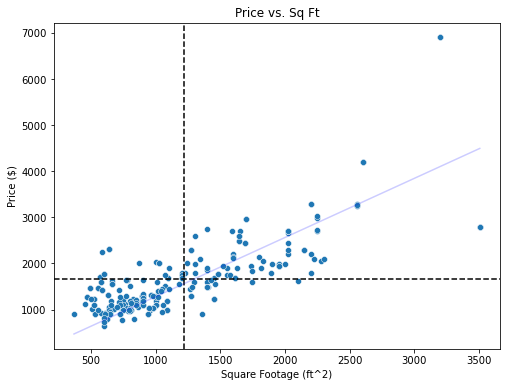

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x='min_sqft', y='min_price', data=df, ax=ax)

ax.axvline(df['min_sqft'].mean(), linestyle='--', color='k')
ax.axhline(df['min_price'].mean(), linestyle='--', color='k')

lm = LinearRegression(fit_intercept=False)
no_na = df.dropna()
X = no_na[['min_sqft']]
y = no_na[['min_price']]
lm.fit(X, y)

xs = np.linspace(df.min_sqft.min(), df.min_sqft.max()).reshape(-1, 1)
ax.plot(xs, lm.predict(xs), linestyle='-', color='blue', alpha=0.2)

ax.set_xlabel('Square Footage (ft^2)')
ax.set_ylabel('Price ($)')
ax.set_title('Price vs. Sq Ft')
plt.show()

## Over Performers -- Big and Cheap

In [61]:
over_performers = df[(df.min_sqft > df.min_sqft.mean()) & (df.min_price < df.min_price.mean())].sort_values(by='min_price')
over_performers

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
129,rent,house,"204 Honour St, Greenville, SC 29611",nan,900.0,900.0,3.0,3.0,2.0,2.0,1360.0,1360.0
123,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0
165,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0
247,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,1272.0,1272.0
268,rent,house,"1024 N Franklin Rd, Greenville, SC 29617",nan,1295.0,1295.0,2.0,2.0,1.0,1.0,1272.0,1272.0
164,rent,apartment,"36 Miracle Dr Unit 1, Greenville, SC 29605",nan,1450.0,1450.0,3.0,3.0,2.0,2.0,1266.0,1266.0
219,rent,apartment,"10 Wrigley St Unit 1, Greenville, SC 29605",nan,1495.0,1495.0,2.0,2.0,2.0,2.0,1400.0,1400.0
64,rent,house,"20 Clearfield Rd, Greenville, SC 29607",nan,1500.0,1500.0,3.0,3.0,2.0,2.0,1407.0,1407.0
207,rent,townhome,"520 Hampton Townes Dr, Greenville, SC 29617",all pets,1500.0,1500.0,3.0,3.0,2.0,2.0,1280.0,1280.0
273,rent,house,"8 Hawthorne Ln, Greenville, SC 29605",all pets,1500.0,1500.0,3.0,3.0,1.0,1.0,1400.0,1400.0


# Geographical Analysis
*Requires Googles API and API key*

In [62]:
with open('secrets.json', 'r') as file:
    secrets = json.load(file)
    API_KEY = secrets['GOOGLE_API_KEY']

In [143]:
def plot_df(df):
	df[['lat', 'lng']] = df.apply(lambda x: get_geo(x['address']), axis=1, result_type='expand')
	df.drop_duplicates(subset=['address'], inplace=True)
	
	street_map = gpd.read_file('gis/Streets.shp')
	street_map = street_map.to_crs('EPSG:4326')

	geometry = [Point(xy) for xy in zip(df['lng'], df['lat'])]
	geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs={'init': 'EPSG:4326'})
	
	hospital_df = pd.DataFrame({
	'location': ['Greenville Memorial Hospital'],
	'lat': [34.8188051257128],
	'lng': [-82.41297623609863]
	})
	hospital_geometry = [Point(xy) for xy in zip(hospital_df['lng'], hospital_df['lat'])]
	hospital_geo_df = gpd.GeoDataFrame(hospital_df, geometry=hospital_geometry, crs={'init': 'EPSG:4326'})

	one_mile = hospital_geo_df.copy()
	one_mile['geometry'] = one_mile['geometry'].buffer(5280/364000)

	two_mile = hospital_geo_df.copy()
	two_mile['geometry'] = two_mile['geometry'].buffer(2*5280/364000)

	five_mile = hospital_geo_df.copy()
	five_mile['geometry'] = five_mile['geometry'].buffer(5*5280/364000)

	fig, ax = plt.subplots(figsize=(15, 15))
	street_map.plot(ax=ax, alpha=0.6, color='grey')
	geo_df.plot(ax=ax, markersize=75, alpha=1, marker='o', column='address', legend=True)
	hospital_geo_df.plot(ax=ax, markersize=150, color='red', marker='^')
	one_mile.boundary.plot(ax=ax, alpha=0.4)
	two_mile.boundary.plot(ax=ax, alpha=0.4)
	five_mile.boundary.plot(ax=ax, alpha=0.4)
	plt.show()

/Users/mattcallicott/opt/anaconda3/envs/playground/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-143-97cdeeea7473>:20: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  one_mile['geometry'] = one_mile['geometry'].buffer(5280/364000)
<ipython-input-143-97cdeeea7473>:23: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  two_mile['geometry'] = two_mile['geometry'].buffer(2*5280/364000)


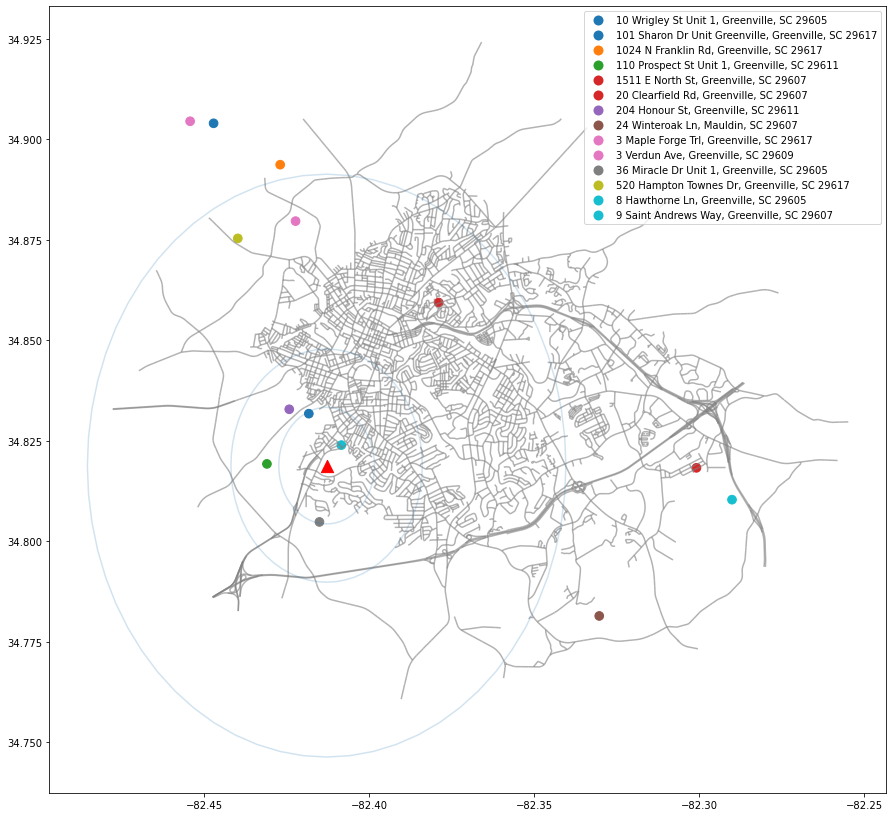

In [144]:
plot_df(over_performers)

# Search Google

In [111]:
def search_google(df):
	for index, row in df.iterrows():
		term = row['address']
		url = f"https://www.google.com.tr/search?q={term}"
		webbrowser.open_new_tab(url)

In [112]:
search_google(over_performers)

# Specific search

In [131]:
specific_df = df[
	(df.min_beds == 0)].drop_duplicates(subset=['address']).sort_values(by='min_price')

specific_df

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
309,rent,apartment,"831 Cleveland St, Greenville, SC 29601",all pets,825.0,1075.0,0.0,2.0,1.0,2.0,600.0,950.0
32,rent,apartment,"75 Mall Connector Rd, Greenville, SC 29607",all pets,899.0,1275.0,0.0,2.0,1.0,1.0,368.0,611.0
77,rent,apartment,"48 McPrice Ct, Greenville, SC 29615",all pets,1013.0,1013.0,0.0,2.0,1.0,2.0,504.0,816.0
78,rent,apartment,"1000 Oak Springs Dr, Greenville, SC 29615",all pets,1102.0,1707.0,0.0,3.0,1.0,2.0,525.0,1424.0
3,rent,apartment,"1600 Azalea Hill Dr, Greenville, SC 29607",all pets,1119.0,1600.0,0.0,2.0,1.0,2.0,450.0,1100.0
34,rent,apartment,"1401 Laurens Rd, Greenville, SC 29607",all pets,1226.0,1929.0,0.0,3.0,1.0,2.0,525.0,1430.0
26,rent,apartment,"18 E Stone Ave Ste 101, Greenville, SC 29609",all pets,1270.0,2103.0,0.0,3.0,1.0,2.0,470.0,2325.0
35,rent,apartment,"27 Station Ct, Greenville, SC 29601",all pets,1310.0,2265.0,0.0,3.0,1.0,2.0,634.0,1587.0
24,rent,apartment,"25 River St, Greenville, SC 29601",all pets,1415.0,2581.0,0.0,2.0,1.0,2.0,584.0,1141.0
37,rent,apartment,"101 Reedy View Dr, Greenville, SC 29601",all pets,1458.0,2485.0,0.0,2.0,1.0,2.0,490.0,1446.0


/Users/mattcallicott/opt/anaconda3/envs/playground/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-130-97cdeeea7473>:20: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  one_mile['geometry'] = one_mile['geometry'].buffer(5280/364000)
<ipython-input-130-97cdeeea7473>:23: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  two_mile['geometry'] = two_mile['geometry'].buffer(2*5280/364000)


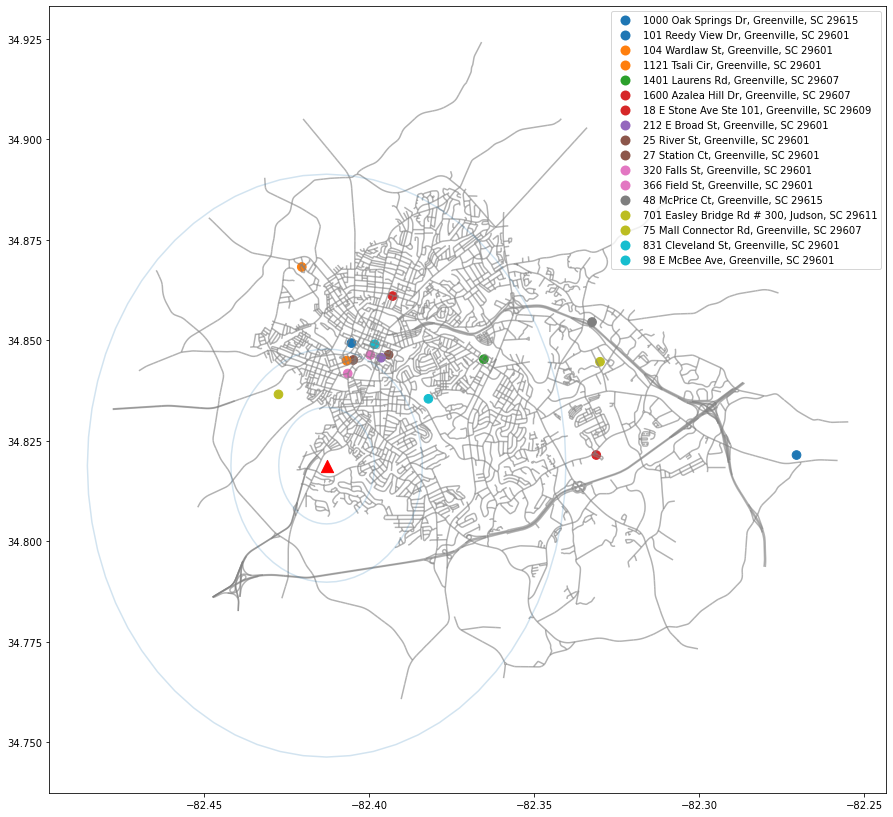

In [132]:
plot_df(specific_df)

In [119]:
search_google(specific_df)